In [13]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from muutils.dictmagic import condense_tensor_dict

In [32]:
def normalize(R):
    with torch.no_grad():
        mean = R.mean(dim=0)
        R = R - mean
        norms = torch.norm(R, p=2, dim=1, keepdim=True)
        R = R/norms
    return R

def cal_cov(R):
    with torch.no_grad():
        Z = torch.nn.functional.normalize(R, dim=1)
        A = torch.matmul(Z.T, Z)/Z.shape[0]
    return A

def cal_entropy(A):
    with torch.no_grad():
        eig_val = torch.svd(A / torch.trace(A))[1] 
        entropy = - (eig_val * torch.log(eig_val)).nansum().item()
        normalized_entropy = entropy/math.log(A.shape[0])
    return normalized_entropy


# Input prompt and transformer lens model, and the model layers number
def entropy_cal_fn(prompt,MODEL,layer_num): 
    TOKENIZER = MODEL.tokenizer
    input_ids = TOKENIZER.encode(prompt)
    logits, cache = MODEL.run_with_cache(
        prompt,
    )

    layers = []
    firstLayer = "blocks.0.hook_resid_post"

    for i in range(layer_num):
        new_string = firstLayer.replace("0", str(i))
        layers.append(new_string)

    Entropy = []

    for i in range(layer_num):
        with torch.no_grad():
            R = cache[layers[i]][0]
            R = normalize(R)
            A = cal_cov(R)
            Entropy.append(cal_entropy(A))

    return Entropy


# Calculate mean and std of matrix entropy of a set of prompt 
def entropy_cal_dataset(prompt,MODEL,layers_num):
    Entropy = []
    for i in range(len(prompt)):
        Entropy.append(entropy_cal_fn(prompt[i], MODEL, layers_num))
    Entropy_np = np.array(Entropy)
    Entropy_means = np.mean(Entropy_np, axis=0)
    Entropy_std = np.std(Entropy_np, axis=0)

    return Entropy_means, Entropy_std
    



In [27]:
MODEL1: HookedTransformer = HookedTransformer.from_pretrained("tiny-stories-3M")
MODEL2: HookedTransformer = HookedTransformer.from_pretrained("gpt2")

Loaded pretrained model tiny-stories-3M into HookedTransformer
Loaded pretrained model gpt2 into HookedTransformer


generate 10 stories each for good and bad stories and test on different models with uncertainty
similiarly also do with condensed version of good and bad stories 
normalize according to the prompt lengths


In [3]:
prompt1 = "The Three Little Pigs is a beloved folk tale that tells the story of three pigs, each building a house out of different materials: straw, sticks, and bricks. The youngest pig opts for straw, the middle pig chooses sticks, while the eldest builds his house out of bricks. When a big bad wolf comes to eat them, he easily destroys the first two houses by huffing and puffing, devouring the first two pigs. However, the third pig's brick house withstands the wolf's attempts. Frustrated, the wolf tries to enter through the chimney, but the clever pig boils a pot of water just in time, ending the wolf's threat once and for all. This classic tale highlights the virtues of hard work and resourcefulness, as the most diligent and smartest pig not only survives but thrives."
prompt2 = "In the gloomy depths of a forsaken city, plagued by perpetual storms and decay, a series of calamities unfolded one after another, casting a shadow of despair across the broken streets. Buildings crumbled under the relentless rain, streets flooded, trapping residents in their homes as cries for help echoed through the night. A mysterious illness swept through the population, its origins unknown, causing widespread panic and chaos. Amidst the pandemonium, crime soared as desperate survivors looted abandoned homes and fought over scarce resources. The city, once bustling with life, turned into a dystopian nightmare where hope dwindled with each passing day, and the darkness seemed to swallow everything in its path."


condense_prompt1 = "The Three Little Pigs is a folk tale about three pigs building houses of straw, sticks, and bricks. A wolf destroys the first two houses and eats the pigs, but fails to break the third pig's brick house. Thwarted, the wolf's final attempt through the chimney ends disastrously, illustrating the rewards of hard work and ingenuity."
condense_prompt2 = "In a forsaken city hit by continuous storms and decay, calamities struck relentlessly. Buildings fell, streets flooded, and a mysterious illness caused chaos and panic. Crime surged as survivors looted and fought over dwindling resources, turning the once vibrant city into a dark, dystopian nightmare where hope faded daily."


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded pretrained model tiny-stories-3M into HookedTransformer
Loaded pretrained model gpt2 into HookedTransformer


In [4]:
Entropy_Tiny_1 = entropy_cal_fn(prompt1,MODEL1,8)
Entropy_Tiny_2 = entropy_cal_fn(prompt2,MODEL1,8)

Entropy_GPT_1 = entropy_cal_fn(prompt1,MODEL2,12)
Entropy_GPT_2 = entropy_cal_fn(prompt2,MODEL2,12)

/var/folders/08/h4ttblxd6m5fjbzyhmxs4bk00000gn/T/ipykernel_41843/2682791777.py:17: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  eig_val = torch.svd(A / torch.trace(A))[1]


In [5]:
Entropy_Tiny_1_cond = entropy_cal_fn(condense_prompt1,MODEL1,8)
Entropy_Tiny_2_cond = entropy_cal_fn(condense_prompt2,MODEL1,8)

Entropy_GPT_1_cond = entropy_cal_fn(condense_prompt1,MODEL2,12)
Entropy_GPT_2_cond = entropy_cal_fn(condense_prompt2,MODEL2,12)

In [133]:
d_model: int = MODEL.cfg.d_model
n_layers: int = MODEL.cfg.n_layers
n_heads: int = MODEL.cfg.n_heads
d_vocab: int = MODEL.cfg.d_vocab
print(f"{d_model=}, {n_layers=}, {n_heads=}, {d_vocab=}")

print(input_ids)
print(MODEL(torch.tensor(input_ids)).shape)
print(MODEL(prompt).shape)
print(condense_tensor_dict(cache, return_format="yaml"))

d_model=768, n_layers=12, n_heads=12, d_vocab=50257
[464, 7683, 7703, 49210, 318, 257, 14142, 15504, 12838, 326, 4952, 262, 1621, 286, 1115, 22333, 11, 1123, 2615, 257, 2156, 503, 286, 1180, 5696, 25, 14787, 11, 16461, 11, 290, 28902, 13, 383, 18887, 12967, 2172, 82, 329, 14787, 11, 262, 3504, 12967, 19769, 16461, 11, 981, 262, 34331, 12188, 465, 2156, 503, 286, 28902, 13, 1649, 257, 1263, 2089, 17481, 2058, 284, 4483, 606, 11, 339, 3538, 27838, 262, 717, 734, 7777, 416, 289, 1648, 278, 290, 33679, 278, 11, 1614, 21823, 262, 717, 734, 22333, 13, 2102, 11, 262, 2368, 12967, 338, 17214, 2156, 25073, 82, 262, 17481, 338, 6370, 13, 1305, 436, 4111, 11, 262, 17481, 8404, 284, 3802, 832, 262, 18205, 1681, 11, 475, 262, 14169, 12967, 40169, 257, 1787, 286, 1660, 655, 287, 640, 11, 7464, 262, 17481, 338, 2372, 1752, 290, 329, 477, 13, 770, 6833, 12838, 11330, 262, 27494, 286, 1327, 670, 290, 8271, 15538, 11, 355, 262, 749, 47334, 290, 44730, 12967, 407, 691, 36417, 475, 19531, 1158, 13]
torch.

## Matrix Entropy across the model layers 

### Tiny story model with good & bad story and also condense version

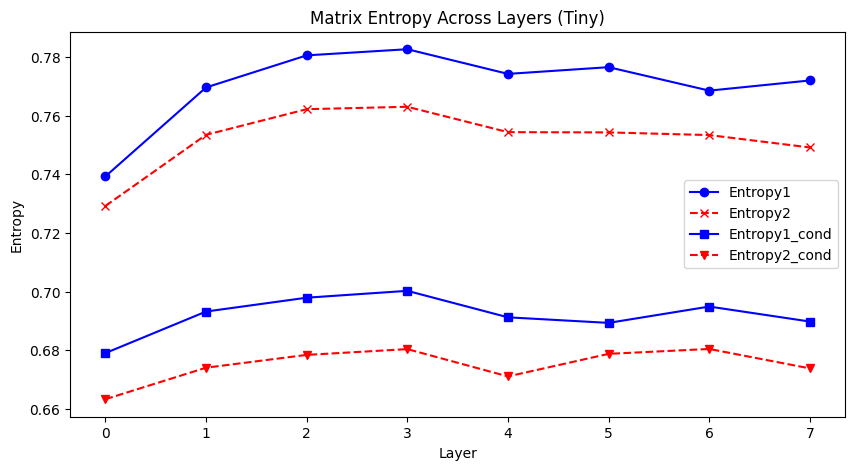

In [6]:
x_values = list(range(len(Entropy_Tiny_1)))

plt.figure(figsize=(10, 5))
plt.plot(x_values, Entropy_Tiny_1, marker='o', linestyle='-', color='b', label='Entropy1')  
plt.plot(x_values, Entropy_Tiny_2, marker='x', linestyle='--', color='r', label='Entropy2') 
plt.plot(x_values, Entropy_Tiny_1_cond, marker='s', linestyle='-', color='b', label='Entropy1_cond')  
plt.plot(x_values, Entropy_Tiny_2_cond, marker='v', linestyle='--', color='r', label='Entropy2_cond')  

plt.legend()
plt.title('Matrix Entropy Across Layers (Tiny)')
plt.xlabel('Layer') 
plt.ylabel('Entropy')  
plt.grid(False) 
plt.xticks(x_values) 
plt.show()

### GPT2 model with good & bad story and also condense version

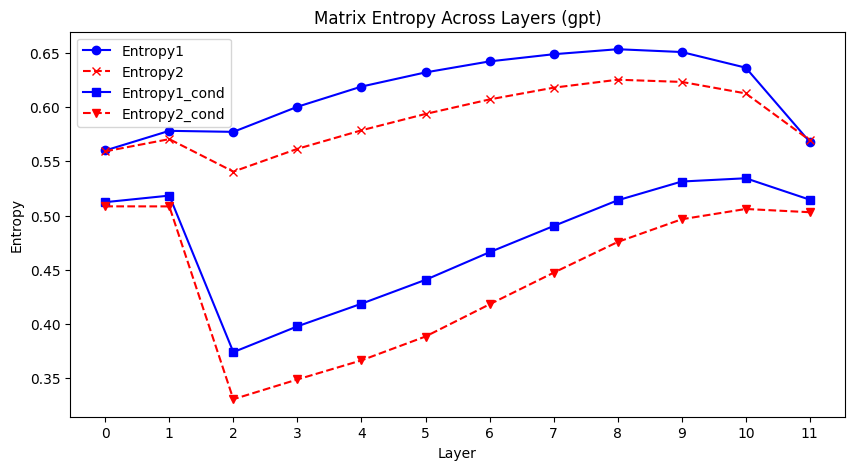

In [7]:
x_values = list(range(len(Entropy_GPT_1)))

plt.figure(figsize=(10, 5))
plt.plot(x_values, Entropy_GPT_1, marker='o', linestyle='-', color='b', label='Entropy1')  
plt.plot(x_values, Entropy_GPT_2, marker='x', linestyle='--', color='r', label='Entropy2') 
plt.plot(x_values, Entropy_GPT_1_cond, marker='s', linestyle='-', color='b', label='Entropy1_cond')  
plt.plot(x_values, Entropy_GPT_2_cond, marker='v', linestyle='--', color='r', label='Entropy2_cond')  

plt.legend()
plt.title('Matrix Entropy Across Layers (gpt)')
plt.xlabel('Layer') 
plt.ylabel('Entropy')  
plt.grid(False) 
plt.xticks(x_values) 
plt.show()

In [16]:
stories_good_long = [
    "In the heart of a sunlit forest lived a cheerful squirrel named Sammy who loved to share his acorns. One day, he met a lost bird named Bella, who couldn't find her way south for the winter. Sammy decided to help by organizing the forest animals into a search team. Together, they found landmarks and used the stars to guide Bella on her journey. Along the way, they encountered challenges like rivers and thick fog, but with teamwork and determination, they overcame them all. Bella was grateful for the help and promised to return next spring with stories of her travels. Sammy learned the value of helping others, and his kindness made him the hero of the forest. His actions inspired other young animals to take initiatives in helping each other, fostering a community of mutual care and support.",
    "Once upon a time, in a small village by the sea, there was a young boy named Tim who dreamed of sailing. He built a small boat with the help of his grandfather, who had been a sailor. After many days of hard work, they launched the boat. On its maiden voyage, Tim rescued a kitten stranded on a floating piece of wood. He named the kitten Splash, and they became inseparable. They went on many adventures, exploring nearby islands and making new friends with dolphins and sea birds. Tim’s bravery and kindness spread throughout the village, inspiring others to take care of the sea and its creatures. His adventures brought not only joy but also a sense of responsibility to the young villagers, who learned the importance of preserving their beautiful coastal home.",
    "Ellie the Elephant was the kindest in her herd, always helping other animals in the savannah. One dry season, the water hole dried up, and Ellie knew she had to help. She remembered an old elephant tale about a hidden spring in the forest. With her friends by her side, Ellie led the way. They faced many obstacles like thorny bushes and steep hills, but Ellie's determination kept everyone going. Finally, they found the spring, bringing water back to all the animals in the savannah. Ellie’s courage and leadership saved her community and proved that even the youngest can make a big difference. Her actions inspired the other animals to look out for each other, strengthening the bonds within the savannah community.",
    "In a bustling city park, Max the Golden Retriever found a lost wallet. Knowing someone might be looking for it, he picked it up and trotted all over the park, sniffing and searching. With help from his park animal friends, he found the owner, an old man who was very worried. The man was so thankful that he threw a big picnic for Max and all his friends. The story of Max’s honesty and perseverance spread, making him a local hero. Max learned that honesty always pays off, and his actions inspired everyone around to do the right thing. His story taught the children in the park about the value of integrity and the impact of good deeds on community cohesion.",
    "High in the mountains lived a brave goat named Gilbert who loved adventures. One afternoon, while climbing, he stumbled upon a young eagle with an injured wing. Gilbert carefully carried the eagle to a vet in the village. After the eagle healed, they both climbed back up the mountain where Gilbert taught the eagle to trust its wings again. The eagle soared high above the mountains, grateful for Gilbert’s help. This act of bravery and friendship was talked about in the village for years, teaching everyone about compassion and courage. Gilbert became a symbol of bravery, and his story encouraged the young ones in the village to take care of the wildlife around them.",
    "In a magical part of the forest, a young witch named Willow found a spellbook that could talk. The book was lonely and wanted to explore the world. Willow and the book set off on a journey to meet other magical beings. They helped a troll find his lost treasure, a fairy fix her broken wings, and a dragon cool down his fiery breath. With each adventure, the spellbook learned more about the world, and Willow learned new spells. Together, they made the forest a happier place for everyone, proving that knowledge and friendship are powerful magic. Their adventures also taught the other creatures in the forest the importance of helping each other and working together to solve problems.",
    "Lily, a small but spirited mouse, lived in an old library. She loved to read about distant lands and daring exploits. One night, she decided to go on an adventure of her own. She helped a young librarian find lost books, solved the mystery of the missing spectacles, and even organized a midnight feast for all the library mice. Her bravery and quick thinking saved the day when a flood threatened the library’s oldest manuscripts. Lily became a legend among the library dwellers, showing that size doesn’t limit one’s ability to make a significant impact. Her stories filled the library with a sense of adventure and curiosity, inspiring the other mice and even the people who visited to explore more and dream bigger.",
    "Deep in the urban jungle, a clever cat named Cleo discovered a garden that was wilting and neglected. She gathered a team of city animals to bring the garden back to life. They cleaned up, planted new seeds, and even built a small pond. The garden flourished, attracting birds and insects back to the area. Cleo and her friends spent many happy days basking in their beautiful oasis. The garden became a symbol of hope and renewal in the city, illustrating the power of initiative and community. This transformation brought the neighborhood together, fostering a shared sense of pride and a new commitment to caring for their environment.",
    "In a cozy village, a young baker named Annie baked the most extraordinary bread. One day, a mysterious old woman asked for a special loaf without paying. Annie agreed, trusting the stranger. The next morning, Annie found her bakery filled with golden loaves. The old woman, a fairy in disguise, rewarded Annie for her kindness. From then on, Annie’s bakery prospered, feeding the whole village during hard times. Her generosity and faith were returned tenfold, teaching her that kindness is the most potent ingredient. The prosperity of her bakery allowed Annie to support local charities and fund community projects, enriching the lives of all the villagers.",
    "On a quiet farm, a young horse named Star learned that he could run faster than the wind. He used his speed to help his farm friends complete their chores quickly. When a storm threatened the farm, Star ran to alert everyone, saving all the animals and crops. His quick actions and caring heart made him a hero on the farm. Star’s story spread far and wide, encouraging others to use their talents to help those around them. His legacy was a reminder that everyone has something special to offer. His example not only improved the farm's operations but also inspired the neighboring farms to work together, leading to a more cooperative and harmonious rural community."
]

 
stories_bad_long = [
    """In a mist-covered town, every full moon, the ghost of a long-lost child whispered through the streets. Curious children followed these whispers to an abandoned mansion, promised hidden treasures. Instead, they found echoes of countless lost souls. The ghost sought friends to join him in eternal silence. Solving the riddle of his disappearance, the children freed the souls. The mansion became a center for paranormal research, attracting scholars eager to communicate with spirits. The children, now called "Whisperers," held workshops teaching others to help trapped spirits. Their efforts culminated in the annual Ghost Festival, celebrating peaceful spirits with lantern releases and mansion tours, turning fearful whispers into messages of wisdom.""",
    """Deep in a shadowy forest lay a forgotten playground where swings moved by themselves, pushed by invisible hands. It was haunted by the spirits of vanished children. On new moon nights, the swings would sway faster, and eerie giggles filled the air. Brave children swinging at midnight glimpsed past shadows, inviting them to an endless ghostly game. The community renovated the playground, adding a “Memory Garden” with sculptures representing each lost child, created by local artists. An annual festival featured plays and puppet shows, symbolizing resilience and renewal. The playground, now a symbol of joy reclaimed from the shadows, taught children the value of memory and community healing.""",
    """In a small village, a mysterious old woman gifted a child a hand-crafted doll, bringing nightmares and dark whispers. The doll grew uglier each night, its whispers revealing the family's fears. Breaking the curse involved placing the doll in the woman’s grave, calming the spirit. Yet, the child, now sensitive to the supernatural, helped other village spirits find peace. Known as the "Little Whisperer," they authored "Whispers and Shadows," detailing their encounters, which became a resource for paranormal researchers. The doll, preserved in a glass case in the village museum, remained a stark reminder of confronting the past’s power.""",
    """An ancient library housed a book never to be read aloud, written in shadows and forgotten languages. When friends inadvertently spoke its words, a spectral figure appeared, haunting their dreams and turning fears into reality. They resealed the book in a ritual of forgotten lore, becoming custodians of mystical knowledge. Their annual meetings evolved into "The Shadows Conclave," debating ethics in magic and supernatural research. They established a secret library of arcane artifacts, accessible only to those understanding the great responsibility that came with such knowledge, serving as a beacon of learning and a line of defense against exploitation.""",
    """Every hundred years, a small isolated town faced terrifying phenomena: reflections in mirrors showed ghastly visages whispering ominous prophecies. A young resident, discovering these spirits were once wronged villagers, embarked on a mission to free them. Each act of righting ancient wrongs tested the child's resolve. Once free, the child became a bridge between natural and supernatural realms, advising the community. The annual Festival of Mirrors drew visitors for storytelling and reflection rituals, helping them connect with their inner selves and the spiritual world, transforming personal trials into triumphs of integrity.""",
    """A child found an old camera with a film showing a shadowy figure approaching. As new pictures were taken, the figure appeared closer in real life, eventually looming outside during a stormy night. Capturing the figure within the film, the child trapped it, but each subsequent photo hinted at its escape. Dubbed "The Eye of Time," the camera was placed in a time capsule, intended for future generations ready for its powers. The child, now a historian, influenced curriculums to emphasize learning from but not reliving history, embedding lessons of hope and caution for a wiser future.""",
    """Deep in a dense forest, a scarecrow believed to protect against evil spirits vanished one night, turning the forest into a maze of terror. Children ventured in to find the scarecrow, returning changed, with no memory. A brave child rediscovered the scarecrow, learning it was a guardian spirit needing help to regain its post. The Harvest Festival now included a ceremony where new scarecrows were blessed by the child, now regarded as the Forest Sage. They trained apprentices in old ways, maintaining balance with nature, and the Great Scarecrow stood as a guardian not just of the forest, but of its spirit.""",
    """On the outskirts of a seaside town, an old pier housed a fortune-telling machine offering accurate predictions at a steep price. A child's inquiry unleashed dire events, leading the community to discover the machine was powered by a long-lost seer's spirit, feeding on resulting misery. The revitalized pier hosted the Festival of Fates, where people shared stories of altered destinies and the power of human spirit. A new exhibit allowed visitors to explore life paths in virtual reality, learning about choices' consequences, a tribute to the machine’s eerie prophecies and lessons on agency.""",
    """A family moved into an old house where an antique music box played at midnight, luring their child into a dream world. Unraveling the music box's history, they discovered it was crafted by a heartbroken artisan whose soul became part of the mechanism. Fulfilling the artisan's unfinished dreams through music, they freed both their child and the spirit. Inspired, the community established "Dream Hubs" supporting artists to complete their projects. Annual galas celebrated these works, with the music box's silent vigil in the museum inspiring "Unfinished Melodies," performances completing unfinished symphonies.""",
    """In a town blanketed with unending night, whispers of a shadowy creature stalking rooftops circulated among children. One adventurous child confronted the creature, discovering it was a guardian keeping darker forces at bay. Choosing to join the guardian, they patrolled together, mastering shadows to protect their home. Their vigil ensured the town's safety, transforming them into a figure of mystery and legend. As the child matured into their role, they became a symbol of protection, ensuring their town's survival against dark forces lurking beyond, teaching future generations the art of shadow mastery."""
]



stories_good_cond = [
    "In a sunlit forest, Sammy the squirrel organized a search team to help Bella the bird find her way south for the winter. Despite challenges like rivers and fog, their teamwork led Bella home safely, inspiring forest animals to support each other, fostering a community of care and mutual support.",
    "Tim, a young boy in a seaside village, built a boat and during its maiden voyage, rescued a kitten named Splash. Their adventures on the sea inspired the village to value and protect their coastal environment, spreading joy and a sense of responsibility among the villagers.",
    "Ellie the Elephant led her friends to find a hidden spring in the savannah during a drought. Her determination and leadership not only brought water back but also strengthened community bonds, proving even the youngest can have a big impact.",
    "Max the Golden Retriever found a lost wallet in the city park and returned it with the help of his animal friends, earning him local hero status. His honesty and perseverance taught park visitors the value of integrity and community support.",
    "Gilbert the goat found an injured eagle and helped it heal and relearn to fly. His bravery made him a village icon, teaching everyone about compassion and the importance of wildlife care.",
    "Willow, a young witch, found a talking spellbook eager to explore the world. Their adventures helped various magical beings and proved that knowledge and friendship are powerful forces for good, enriching the forest community.",
    "Lily, a mouse living in an old library, embarked on an adventure to help a librarian, showcasing her bravery. Her actions during a flood saved precious manuscripts and inspired all library dwellers with a sense of adventure and curiosity.",
    "Cleo the cat revitalized a wilting garden in an urban jungle, transforming it into a flourishing community space that brought neighbors together and fostered environmental stewardship.",
    "Annie, a young baker, received a mysterious visitor who rewarded her kindness with magical golden loaves, leading to prosperity for her village bakery. Her generosity benefited the entire community, emphasizing that kindness is a powerful force.",
    "Star the horse used his speed to save his farm from a storm, proving his heroism. His actions inspired others to use their talents for the good of all, enhancing community cooperation and harmony."
]



stories_bad_cond = [
    "In a mist-covered town, every full moon, the ghost of a long-lost child lured children to an abandoned mansion with promises of treasures. Inside, a boy found the echoes of trapped souls, revealing the mansion's haunting past.",
    "A forgotten playground deep in a shadowy forest moved by itself, haunted by the spirits of vanished children. At midnight, eerie giggles and fleeting shadows appeared, chilling any who dared swing on its swings.",
    "A mysterious old woman in a village gifted a child a cursed doll that whispered dark secrets at night and became grotesque. The curse was broken only when the family returned the doll to the woman's grave.",
    "An ancient library held a forbidden book that unleashed a spectral figure haunting the readers' dreams, turning spoken secrets into terrifying realities.",
    "Every century, a small town faced a curse where mirrors showed not reflections but ghastly visages that whispered ominous prophecies. A brave child discovered these were spirits needing liberation from an ancient wrong.",
    "A child found an old camera with a film revealing a shadowy figure that appeared closer with each photo, eventually manifesting outside during a stormy night.",
    "A protective scarecrow in a dense forest vanished one night, turning the forest into a terrifying labyrinth with whispering trees and unseen watchers, changing those who searched for it.",
    "At a dilapidated pier, a fortune-telling machine accurately predicted dire events at a cost, sowing chaos until it mysteriously disappeared after unsettling the town.",
    "A family moved into a house with an antique music box that played hypnotic tunes at midnight, trapping their child in a dream world. Solving the music box's riddle involved uncovering a tragic past.",
    "In a town engulfed in perpetual darkness, rumors of a shadowy rooftop creature led a child to confront it, only to learn it was a guardian against darker forces, presenting the child with a life-altering choice."
]




In [35]:
Entropy_GPT_good_long_mean, Entropy_GPT_good_long_std = entropy_cal_dataset(stories_good_long,MODEL2,12)
Entropy_GPT_bad_long_mean, Entropy_GPT_bad_long_std = entropy_cal_dataset(stories_bad_long,MODEL2,12)

In [41]:
Entropy_GPT_good_cond_mean, Entropy_GPT_good_cond_std = entropy_cal_dataset(stories_good_cond,MODEL2,12)
Entropy_GPT_bad_cond_mean, Entropy_GPT_bad_cond_std = entropy_cal_dataset(stories_bad_cond,MODEL2,12)

## Mean Matrix Entropy Across Layers 

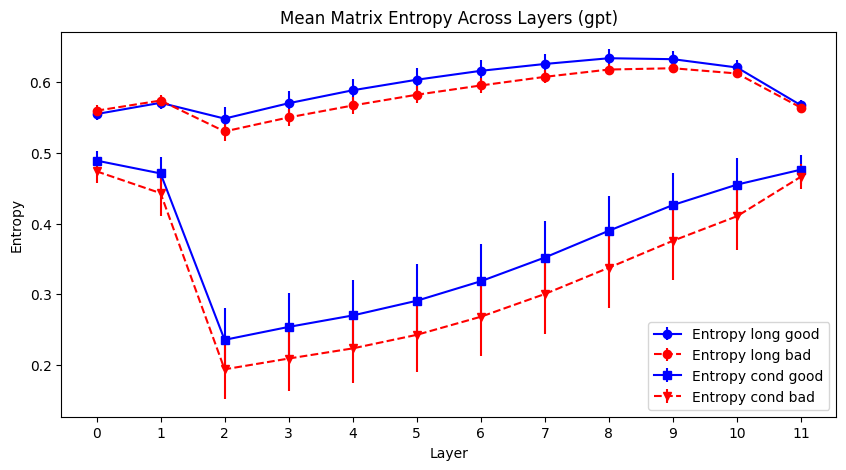

In [43]:
x_values = list(range(len(Entropy_GPT_good_long_mean)))

plt.figure(figsize=(10, 5))
plt.errorbar(x_values, Entropy_GPT_good_long_mean, yerr=Entropy_GPT_good_long_std, marker='o', linestyle='-', color='b', label='Entropy long good')
plt.errorbar(x_values, Entropy_GPT_bad_long_mean, yerr=Entropy_GPT_bad_long_std, marker='o', linestyle='--', color='r', label='Entropy long bad')

plt.errorbar(x_values, Entropy_GPT_good_cond_mean, yerr=Entropy_GPT_good_cond_std, marker='s', linestyle='-', color='b', label='Entropy cond good')
plt.errorbar(x_values, Entropy_GPT_bad_cond_mean, yerr=Entropy_GPT_bad_cond_std, marker='v', linestyle='--', color='r', label='Entropy cond bad')
plt.legend()
plt.title('Mean Matrix Entropy Across Layers (gpt)')
plt.xlabel('Layer') 
plt.ylabel('Entropy')  
plt.grid(False) 
plt.xticks(x_values) 
plt.show()